### 1: Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

In [2]:
import sys
print(sys.executable)

b:\Dublin City University\Practicum\Proj\.venv\Scripts\python.exe


### 2: Load and Explore Dataset

In [3]:
multimodal = pd.read_csv("B:/Dublin City University/Practicum/Proj/Dataset/main/processed/multimodal_dataset_final_v4_1.csv")
multimodal.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Log_Returns,Volatility_Log_10,cl-op,...,total_question_intent,total_action_intent,sentiment_minus_uncertainty,sentiment_minus_fear,sentiment_minus_action,sentiment_minus_urgency,sentiment_minus_prediction,Next_3_Close,Next_7_Close,Next_Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,NaN,NaN,25.128907,...,0.363636,0.500,0.025843,-0.974157,-0.974157,0.025843,-0.307490,17409.720703,17780.830078,17929.990234
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,-0.001080,NaN,217.230468,...,0.363636,0.250,-0.238229,-0.238229,-0.071562,0.428438,-0.238229,17140.240234,17829.730469,17694.679688
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,-0.013211,NaN,238.660157,...,0.454545,0.375,0.197063,-0.136270,-0.552937,-0.302937,0.197063,17400.750000,17804.869141,17409.720703
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,-0.016235,NaN,219.210937,...,0.545455,0.375,-0.642541,0.024126,-0.725874,-0.475874,-0.642541,18011.070312,17675.160156,17140.240234
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-0.015600,NaN,-214.970704,...,0.181818,0.375,-0.571208,-0.237874,-0.654541,-0.404541,-0.571208,17780.830078,17733.099609,17400.750000


In [4]:
missing_values = multimodal.isnull().sum()
print("\nMissing values per column:")
missing_values[missing_values > 0]


Missing values per column:


Log_Returns           1
Volatility_Log_10    10
pct_change            1
Next_3_Close          3
Next_7_Close          7
Next_Close            1
dtype: int64

In [5]:
multimodal.describe()
multimodal.dtypes

Date                            object
Open                           float64
High                           float64
Low                            float64
Close                          float64
Volume                           int64
Adj Close                      float64
Log_Returns                    float64
Volatility_Log_10              float64
cl-op                          float64
hi-lo                          float64
Label                            int64
vader_news_sentiment           float64
FinBERT_news_sentiment         float64
Smart_news_sentiment           float64
news_buying_intent             float64
news_selling_intent            float64
news_uncertainty_intent        float64
news_urgency_intent            float64
news_prediction_intent         float64
news_fear_intent               float64
news_greed_intent              float64
news_question_intent           float64
news_action_intent             float64
vader_reddit_sentiment         float64
FinBERT_reddit_sentiment 

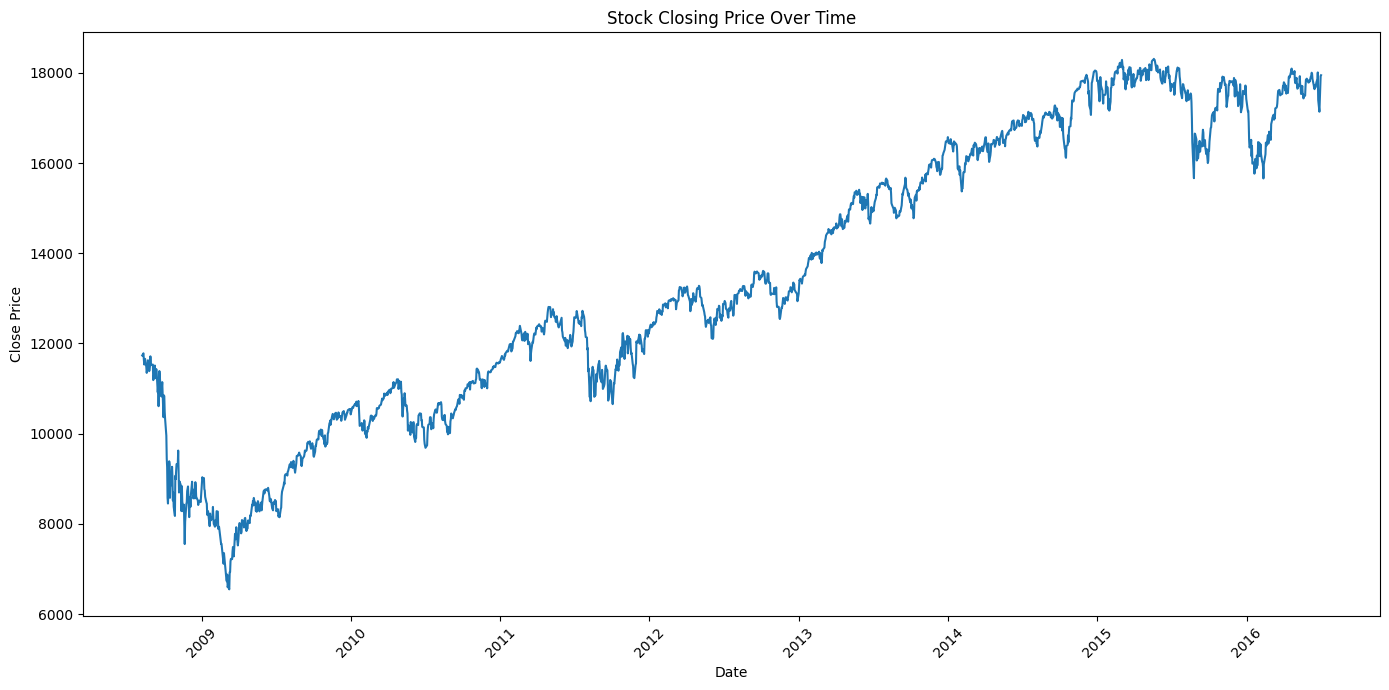

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(multimodal['Date']), multimodal['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3: Data Preprocessing

In [6]:
# Force to string to ensure str methods work
multimodal['Date'] = multimodal['Date'].astype(str)
multimodal['Date'] = multimodal['Date'].str.strip()

In [7]:
multimodal['Date'] = pd.to_datetime(multimodal['Date'], format='%Y-%m-%d')
multimodal['Date'].dtype

dtype('<M8[ns]')

In [ ]:
multimodal_processed = multimodal.copy()

# Fill missing volatility values with rolling standard deviation
multimodal_processed['Volatility'] = multimodal_processed['Volatility'].fillna(
    multimodal_processed['Close'].rolling(window=10).std()
    )

multimodal_processed['pct_change'] = multimodal_processed['pct_change'].fillna(
        multimodal_processed['Close'].pct_change()
    )

# Drop the last row which will have NaN in Next_Close
multimodal_processed = multimodal_processed.dropna()

print(f"Shape after preprocessing: {multimodal_processed.shape}")
print("Missing values after preprocessing:")
print(multimodal_processed.isnull().sum())


Shape after preprocessing: (1979, 15)
Missing values after preprocessing:
Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
Adj Close           0
Volatility          0
news_sentiment      0
Label               0
reddit_sentiment    0
Target              0
pct_change          0
final_sentiment     0
Next_Close          0
dtype: int64


In [9]:
multimodal_processed.dtypes

Date                datetime64[ns]
Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                       int64
Adj Close                  float64
Volatility                 float64
news_sentiment             float64
Label                        int64
reddit_sentiment           float64
Target                       int64
pct_change                 float64
final_sentiment            float64
Next_Close                 float64
dtype: object

In [10]:
multimodal_processed.set_index('Date', inplace=True)

In [11]:
multimodal_processed.sort_index(inplace=True)

In [12]:
print(pd.date_range(start=multimodal_processed.index.min(), end=multimodal_processed.index.max()).difference(multimodal_processed.index))

DatetimeIndex(['2008-08-16', '2008-08-17', '2008-08-23', '2008-08-24',
               '2008-08-30', '2008-08-31', '2008-09-01', '2008-09-06',
               '2008-09-07', '2008-09-13',
               ...
               '2016-05-22', '2016-05-28', '2016-05-29', '2016-05-30',
               '2016-06-04', '2016-06-05', '2016-06-11', '2016-06-12',
               '2016-06-18', '2016-06-19'],
              dtype='datetime64[ns]', length=892, freq=None)


In [13]:
# total 2864 days and approximately 409.14 weeks
# missing values(predictable) are weekly holidays (saturday and sunday) -> 409.14 * 2 = 818.28 - classic case of MAR - Missing at Random
# other missing values can be the public holidays which are random (again MAR)
# need to verify this firmly if 'ALL OF THE' missing values are because of public holidays and not some other causes - will need other dataset containing record of public dataset
# public holidays are periods of inactivity - hence should not be filled/imputed or edited in any way
# could aggregate the data to periods (weekly or monthly) but only have ~2900 rows on a daily basis, aggregating this would shrink the data and neural networks like LSTM wont
# perform well on this - hence will need to stick to daily data and use a different approach to handle missing

In [13]:
# only uses business days and excludes weekends (pandas library), but public holidays still needs addressing
multimodal_processed = multimodal_processed.asfreq('B')

In [14]:
print(pd.date_range(start=multimodal_processed.index.min(), end=multimodal_processed.index.max()).difference(multimodal_processed.index))

DatetimeIndex(['2008-08-16', '2008-08-17', '2008-08-23', '2008-08-24',
               '2008-08-30', '2008-08-31', '2008-09-06', '2008-09-07',
               '2008-09-13', '2008-09-14',
               ...
               '2016-05-21', '2016-05-22', '2016-05-28', '2016-05-29',
               '2016-06-04', '2016-06-05', '2016-06-11', '2016-06-12',
               '2016-06-18', '2016-06-19'],
              dtype='datetime64[ns]', length=820, freq=None)


In [15]:
start_date = multimodal_processed.index.min()
end_date = multimodal_processed.index.max()

# Generate the full date range
full_date_range = pd.date_range(start=start_date, end=end_date)

# Count the number of Saturdays and Sundays
weekend_days = np.sum(full_date_range.weekday >= 5)  # 5 = Saturday, 6 = Sunday
print("Total Weekend Days (Expected):", weekend_days)

Total Weekend Days (Expected): 820


In [16]:
duplicate_dates = multimodal_processed.index.duplicated().sum()
print("Total Duplicate Dates:", duplicate_dates)

Total Duplicate Dates: 0


In [17]:
print("Date Range (Index):", multimodal_processed.index.min(), "to", multimodal_processed.index.max())
print("DataFrame Shape:", multimodal_processed.shape)

Date Range (Index): 2008-08-11 00:00:00 to 2016-06-20 00:00:00
DataFrame Shape: (2051, 14)


In [19]:
import pandas_market_calendars as mcal

# Define the NYSE calendar
nyse = mcal.get_calendar('XNYS')

# Get the valid trading days for the full date range
start_date = multimodal_processed.index.min()
end_date = multimodal_processed.index.max()
trading_days = nyse.schedule(start_date=start_date, end_date=end_date)

# Convert to a flat date index
valid_trading_days = pd.date_range(start=trading_days.index.min(), end=trading_days.index.max(), freq='B')

# Check for remaining gaps
remaining_gaps = valid_trading_days.difference(multimodal_processed.index)
print("\nRemaining Gaps After Applying NYSE Calendar:")
print(remaining_gaps)
print("\nTotal Remaining Gaps:", len(remaining_gaps))


ModuleNotFoundError: No module named 'pandas_market_calendars'

In [19]:
import sys
print(sys.executable)

C:\Users\abhis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


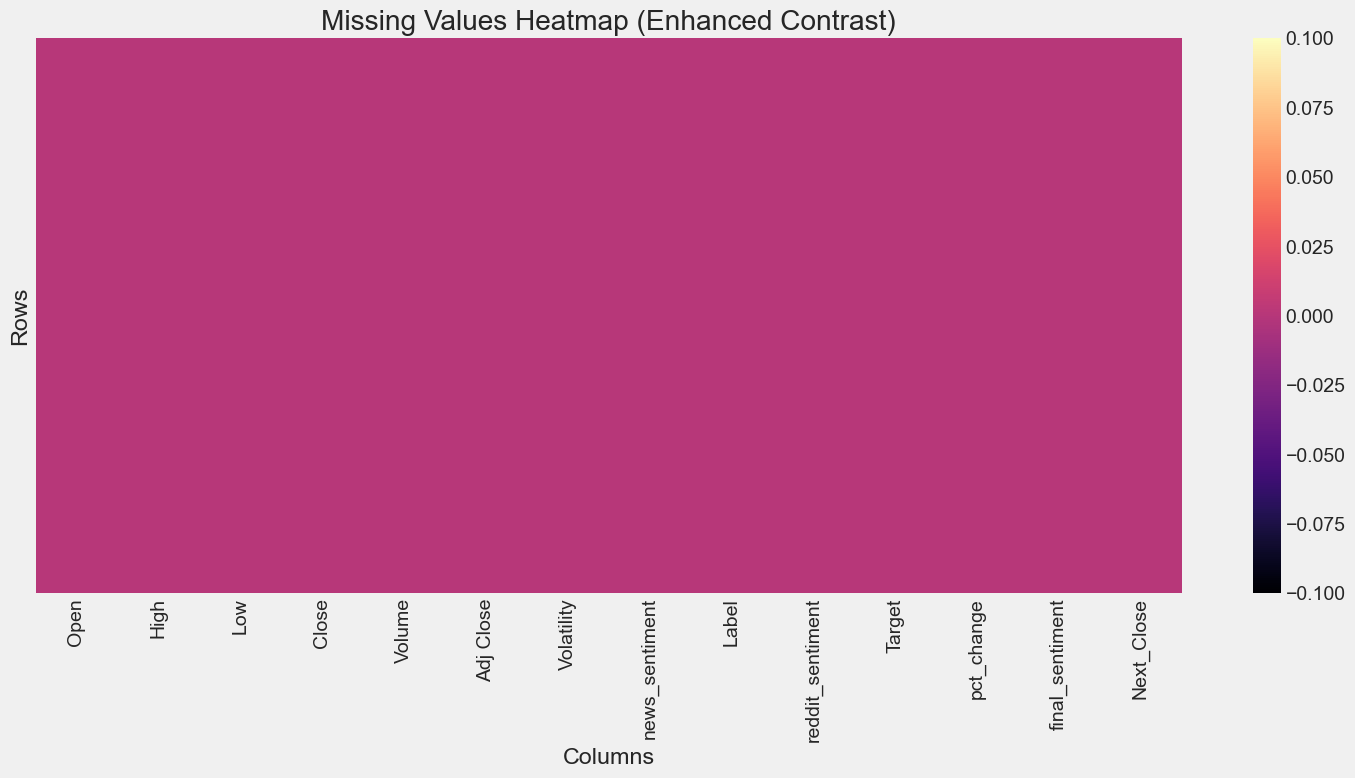

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(multimodal_processed.isna(), cmap='magma', cbar=True, yticklabels=False)
plt.title("Missing Values Heatmap (Enhanced Contrast)")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

In [101]:
multimodal_processed.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
Adj Close           0
Volatility          0
news_sentiment      0
Label               0
reddit_sentiment    0
Target              0
pct_change          0
final_sentiment     0
Next_Close          0
dtype: int64

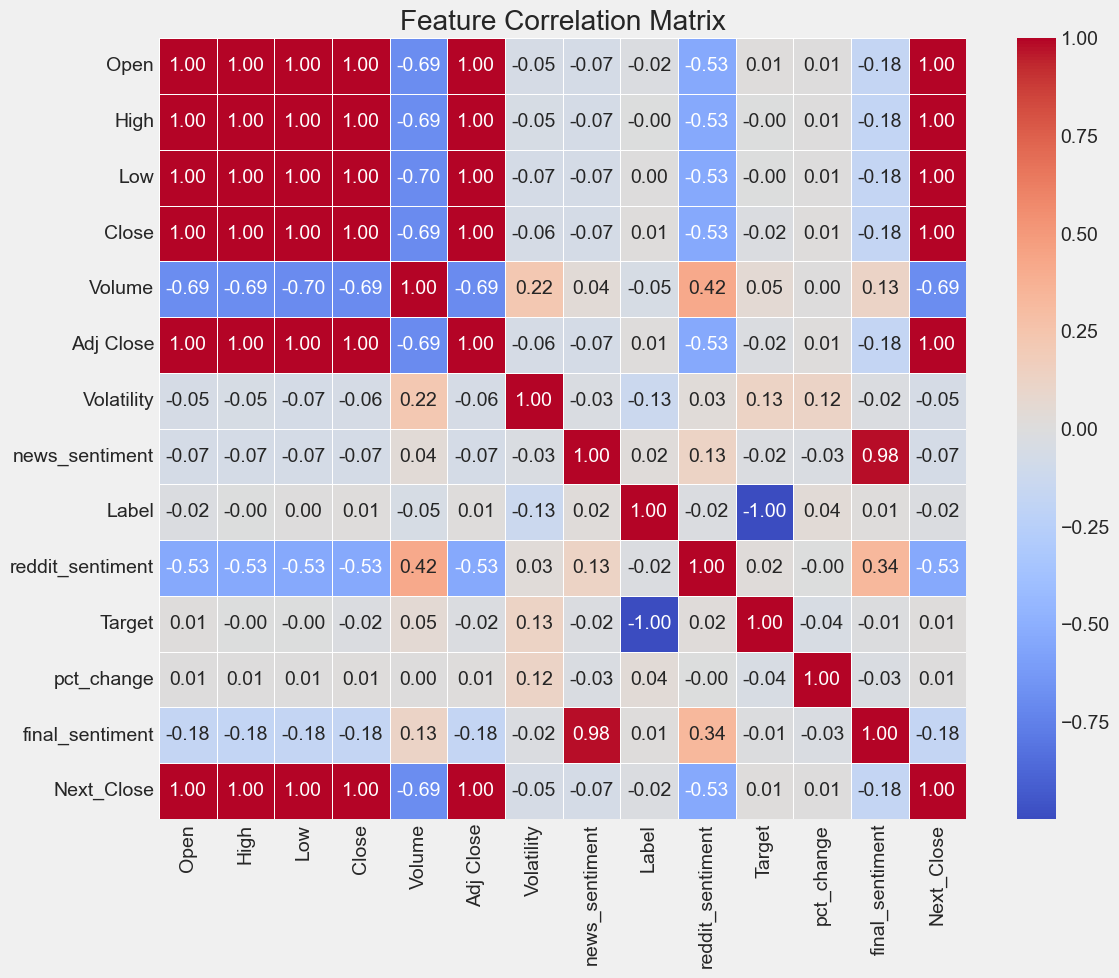

In [96]:
# Plot correlation matrix
plt.figure(figsize=(12, 10))
numeric_columns = multimodal_processed.select_dtypes(include=[np.number]).columns
correlation_matrix = multimodal_processed[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

### 4: Time Series Stationarity Analysis for ARIMA

Text(0, 0.5, 'Price')

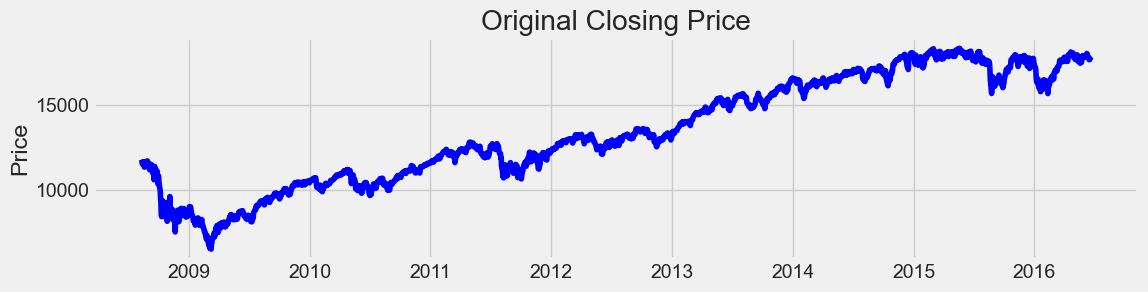

In [77]:
# Plot the original closing price
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
# plt.plot(multimodal_processed['Date'], multimodal_processed['Close'], color='blue')
plt.plot(multimodal_processed.index, multimodal_processed['Close'], color='blue')
plt.title('Original Closing Price')
plt.ylabel('Price')

In [63]:
multimodal_processed.index

DatetimeIndex(['2016-06-20', '2016-06-17', '2016-06-16', '2016-06-15',
               '2016-06-14', '2016-06-13', '2016-06-10', '2016-06-09',
               '2016-06-08', '2016-06-07',
               ...
               '2008-08-22', '2008-08-21', '2008-08-20', '2008-08-19',
               '2008-08-18', '2008-08-15', '2008-08-14', '2008-08-13',
               '2008-08-12', '2008-08-11'],
              dtype='datetime64[ns]', name='Date', length=1979, freq=None)

In [ ]:
# Conduct Augmented Dickey-Fuller test on the original series
result = adfuller(multimodal_processed['Close'].dropna())
print(f"ADF Statistic (original): {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.4f}")

is_stationary = result[1] < 0.05
print(f"Original series is {'stationary' if is_stationary else 'non-stationary'}")

ADF Statistic (original): -1.3159
p-value: 0.6218
Critical Values:
	1%: -3.4337
	5%: -2.8630
	10%: -2.5676
Original series is non-stationary



ADF Statistic (diff order 1): -21.6368
p-value: 0.0000
Differenced series (order 1) is stationary


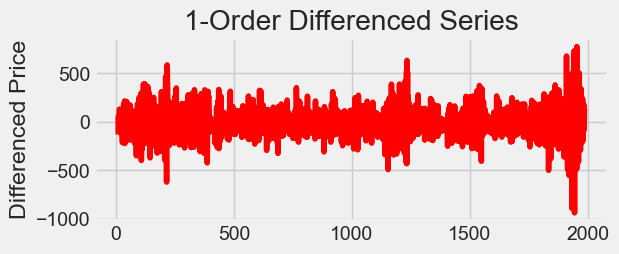

In [ ]:
diff_order = 0
diff_series = multimodal_processed['Close']

while not is_stationary and diff_order < 2:
    diff_order += 1
    diff_series = diff_series.diff().dropna()

    # Plot the differenced series
    plt.subplot(2, 1, 2)
    plt.plot(diff_series.index, diff_series, color='red')
    plt.title(f'{diff_order}-Order Differenced Series')
    plt.ylabel('Differenced Price')

    # Check stationarity again
    result = adfuller(diff_series.dropna())
    print(f"\nADF Statistic (diff order {diff_order}): {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    is_stationary = result[1] < 0.05
    print(f"Differenced series (order {diff_order}) is {'stationary' if is_stationary else 'non-stationary'}")
plt.tight_layout()
plt.savefig('stationarity_analysis.png')
plt.show()
plt.close()

### 5: Data Splitting and Scalling

In [ ]:
# Determine the split point
test_size=0.2
split_idx = int(len(multimodal_processed) * (1 - test_size))
print(f"Training set size: {split_idx}, Test set size: {len(multimodal_processed) - split_idx}")

# For ARIMA model - only need the 'Close' price
arima_train = multimodal_processed.iloc[:split_idx]['Close']
arima_test = multimodal_processed.iloc[split_idx:]['Close']

# Select relevant features for LSTM
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'pct_change']

features.extend(['news_sentiment', 'reddit_sentiment', 'final_sentiment'])

Training set size: 1583, Test set size: 396


In [ ]:
X = multimodal_processed[features].values
y = multimodal_processed['Next_Close'].values

# Split into train and test sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale the data for LSTM
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

print("Data scaled successfully")

Data scaled successfully


In [38]:
seq_length = 60  # Using 60 days of data to predict

# Create sequences for LSTM
X_train_seq, y_train_seq = [], []
X_test_seq, y_test_seq = [], []

# Generate training sequences
for i in range(len(X_train_scaled) - seq_length):
    X_train_seq.append(X_train_scaled[i:i+seq_length])
    y_train_seq.append(y_train_scaled[i+seq_length])

# Generate testing sequences
for i in range(len(X_test_scaled) - seq_length):
    X_test_seq.append(X_test_scaled[i:i+seq_length])
    y_test_seq.append(y_test_scaled[i+seq_length])

# Convert to NumPy arrays
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# Print the shapes for verification
print(f"LSTM sequence shape - X_train: {X_train_seq.shape}, y_train: {y_train_seq.shape}")
print(f"LSTM sequence shape - X_test: {X_test_seq.shape}, y_test: {y_test_seq.shape}")

# Extract corresponding test dates (aligning with sequence lengths)
test_dates = multimodal_processed.index[split_idx + seq_length:]

# Print a sample to verify
print("\nSample Training Sequence:")
print(X_train_seq[0])
print("\nSample Test Sequence:")
print(X_test_seq[0])

LSTM sequence shape - X_train: (1523, 60, 10), y_train: (1523, 1)
LSTM sequence shape - X_test: (336, 60, 10), y_test: (336, 1)

Sample Training Sequence:
[[0.93299113 0.95279989 0.9381293  0.94116314 0.14059409 0.37780364
  0.39524121 0.21898866 0.38411377 0.24627422]
 [0.93259365 0.92798547 0.92264233 0.926126   0.37133717 0.35749881
  0.33598101 0.31194747 0.32357792 0.29685431]
 [0.91738733 0.93048774 0.90745562 0.93284291 0.12911103 0.33709318
  0.44224563 0.1875     0.46612683 0.24945345]
 [0.92914128 0.931426   0.92567187 0.92206959 0.13248022 0.33635225
  0.3565494  0.21419937 0.32612024 0.22348612]
 [0.92996634 0.92804146 0.92183498 0.9260866  0.13187747 0.31735162
  0.42902949 0.1875     0.41413112 0.23228201]
 [0.94384238 0.94661376 0.93749181 0.93277113 0.14416419 0.19472176
  0.4420873  0.1875     0.49006572 0.25735919]
 [0.95639604 0.95192127 0.94684593 0.94817349 0.12693187 0.1296872
  0.4846428  0.28654001 0.25493235 0.25489563]
 [0.96000732 0.9596598  0.9588046  0.9620

### 6: ARIMA Model

In [42]:
multimodal_processed['Date'].describe()

count           1979
unique          1979
top       2008-08-11
freq               1
Name: Date, dtype: object

Building ARIMA(5,1,1) model...


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1583
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9915.861
Date:                Wed, 14 May 2025   AIC                          19845.721
Time:                        00:32:25   BIC                          19883.286
Sample:                             0   HQIC                         19859.678
                               - 1583                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0933      0.276      0.338      0.735      -0.447       0.634
ar.L2          0.0219      0.019      1.131      0.258      -0.016       0.060
ar.L3         -0.0225      0.020     -1.130      0.2

C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


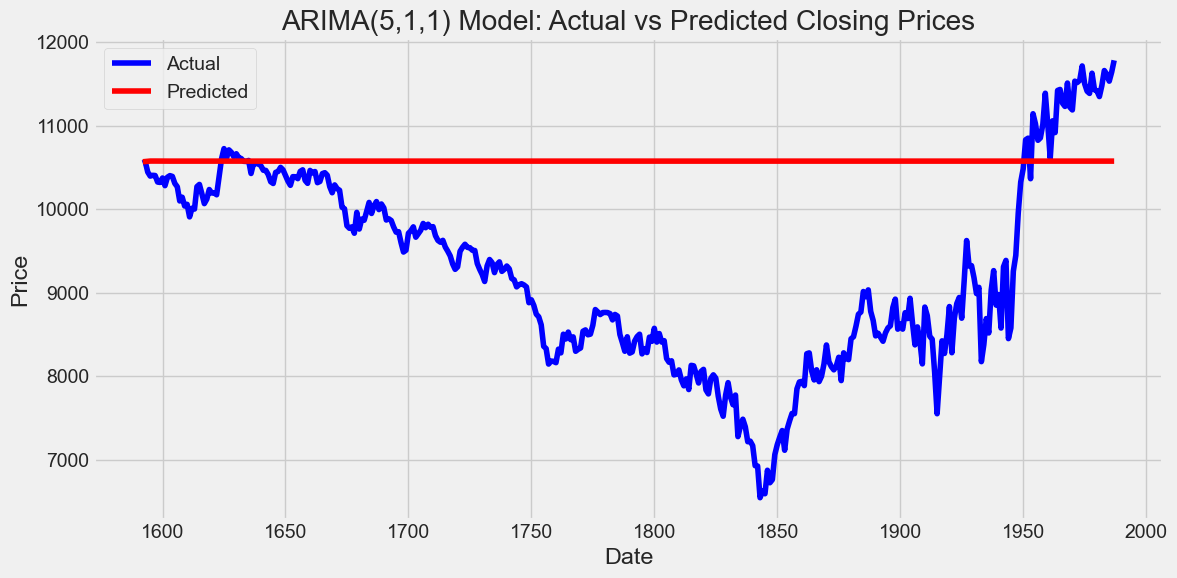


Sample Predictions:
1583    10568.212160
1584    10570.992818
1585    10573.279465
1586    10576.595578
1587    10577.010090
Name: predicted_mean, dtype: float64


In [39]:
# Extract ARIMA training and testing data
train_data = multimodal_processed['Close'][:split_idx]
test_data = multimodal_processed['Close'][split_idx:]
test_dates = multimodal_processed.index[split_idx:]

# Define ARIMA parameters (predefined for simplicity)
p, d, q = 5, diff_order, 1
print(f"Building ARIMA({p},{d},{q}) model...")

# Build and fit ARIMA model
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# Make predictions
predictions = model_fit.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

print("\nARIMA Model Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

# Plot the predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_data, color='blue', label='Actual')
plt.plot(test_dates, predictions, color='red', label='Predicted')
plt.title(f'ARIMA({p},{d},{q}) Model: Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig('arima_predictions.png')
plt.show()
plt.close()

# Print a sample of the predictions for verification
print("\nSample Predictions:")
print(predictions[:5])

### 7: LSTM Regression model